In [1]:
"""
Functions for random parameter search.
"""

import os
import pickle
import numpy as np
import math
import optuna

import matplotlib.pyplot as plt
from numba import jit
from time import time
from tqdm import tqdm
from datetime import datetime
from multiprocessing import Pool
from scipy.integrate import odeint
from scipy.signal import periodogram
#https://stackoverflow.com/questions/31070563/find-all-local-maxima-and-minima-when-x-and-y-values-are-given-as-numpy-arrays/31073798

from scipy.signal import find_peaks


import warnings
warnings.filterwarnings("ignore")
error_message = 'Excess work done on this call (perhaps wrong Dfun type).'

3


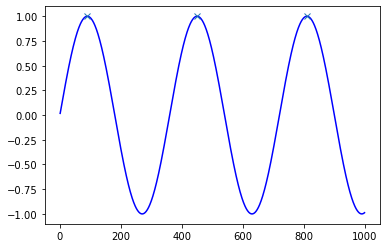

In [2]:



#test plot and peak count

# グラフ横軸
x = range(1,1000)
# サイン波の生成
y = np.array([math.sin(math.radians(ms)) for ms in x])

peaks, _ = find_peaks(y)

print(len(peaks))

# グラフ表示
plt.plot(x, y, label='sin', color='blue')
plt.plot(peaks, y[peaks], "x")
plt.show()


In [3]:
@jit(nopython=True)
def DvD(S, t, k, K):
    """
    The function of the system for scipy.integrate.odeint.
    
    Parameters
    --------------
    S : array
    Condition of substrates 
    t : array
    A sequence of time points.
    k : array
    Rate constants.
    K: array
    MM constants.
    
    Returns
    ----------
    Sintg : array
    The change of S.
    """
    
    Sintg = np.empty(6)
    Sa_00, Sa_01, Sa_10, Sb_00, Sb_01, Sb_10 = S
    
    E = 20./(1 + Sa_00/K[0] + Sa_00/K[1] + Sa_01/K[2]   + Sa_10/K[3]
                  + Sb_00/K[8] + Sb_00/K[9] + Sb_01/K[10] + Sb_10/K[11])
    F = 20./(1 + Sa_01/K[4]   + Sa_10/K[5]   + (1000.-Sa_00-Sa_01-Sa_10)/K[6]   + (1000.-Sa_00-Sa_01-Sa_10)/K[7]
                  + Sb_01/K[12] + Sb_10/K[13] + (1000.-Sb_00-Sb_01-Sb_10)/K[14] + (1000.-Sb_00-Sb_01-Sb_10)/K[15])
             
    Sintg[0] = - k[0]*E*Sa_00/K[0] - k[1]*E*Sa_00/K[1] + k[4]*F*Sa_01/K[4] + k[5]*F*Sa_10/K[5]
    Sintg[1] = - k[4]*F*Sa_01/K[4] - k[2]*E*Sa_01/K[2] + k[0]*E*Sa_00/K[0] + k[6]*F*(1000.-Sa_00-Sa_01-Sa_10)/K[6]
    Sintg[2] = - k[5]*F*Sa_10/K[5] - k[3]*E*Sa_10/K[3] + k[1]*E*Sa_00/K[1] + k[7]*F*(1000.-Sa_00-Sa_01-Sa_10)/K[7]
    Sintg[3] = - k[8]*E*Sb_00/K[8] - k[9]*E*Sb_00/K[9] + k[12]*F*Sb_01/K[12] + k[13]*F*Sb_10/K[13]
    Sintg[4] = - k[12]*F*Sb_01/K[12] - k[10]*E*Sb_01/K[10] + k[8]*E*Sb_00/K[8] + k[14]*F*(1000.-Sb_00-Sb_01-Sb_10)/K[14]
    Sintg[5] = - k[13]*F*Sb_10/K[13] - k[11]*E*Sb_10/K[11] + k[9]*E*Sb_00/K[9] + k[15]*F*(1000.-Sb_00-Sb_01-Sb_10)/K[15]
             
    return(Sintg)

@jit
def check_convergence(v, trange, epsilon=1.0):
    """
    Judge if each state of a substrate is convergent.
    
    Parameters
    --------------
    v : array
    A sequence of a state of a substrate.
    trange : int
    The time the integration was done.
    epsilon : scalar
    A threshold for the judge.
    
    Returns
    ----------
    1 if not convergence.
    """
    
    rang = trange//10
    
    # check convergence
    vstd = np.std(v[-rang:])
    
    diffstd = np.std(np.diff(v[-rang:]))
    if diffstd < epsilon:
        return(3)
    elif vstd < epsilon:
        return(0)
    else:
        return(1) # not convergence
    
def gen_kK():
    """
    Randomly generate 32 parameters that determine the system.
    
    Returns
    ----------
    k : array
    Rate constants.
    K : array
    MM constants.
    """
    
    rk = np.random.rand(16)#0.0以上、1.0未満
    rK = np.random.rand(16)#0.0以上、1.0未満
    
    k = 10**(3*rk)# max10^3
    K = 10**(5*rK-2)# max10^(5-2)
    
    return(k, K)

def random_search(args):
    """
    Iterate random parameter generation and classification of chaotic solutions.
    
    Parameters
    --------------
    args : tuple, shape (2)
        i_core : int
            Specify which cpu core is used.
        n_iter : int
            How much iteration is done by each cpu core.
    """
    
    i_core, n_iter = args
    
    S0 = np.asarray([1000., 0., 0., 1000., 0., 0.]) # initial state of the substrates.
    
    now = datetime.now()
    date = '{}_{}_{}_{}_{}_{}_{}'.format(now.year, now.month, now.day, now.hour, now.minute, now.second, i_core)
    np.random.seed(int('{}_{}_{}_{}_'.format(i_core, now.day, now.hour, now.minute)+str(now.microsecond)[-4:-2]))
    
    # the path to save the search results.
    filename = './random_{:02}.pickle'.format(i_core)
    #filename_osci = './random_{:02}_osci.pickle'.format(i_core)

    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            ongoing = pickle.load(f)
            i_iter = ongoing[0]
            n_osci = ongoing[1]
            chaos_maybe = ongoing[2:]
        #with open(filename_osci, 'rb') as f:
        #    osci_maybe = pickle.load(f)

    else:
        i_iter = np.zeros(1)
        n_osci = np.zeros(1)
        chaos_maybe = []
        #osci_maybe = []

    judge = np.zeros(6, dtype='int')

    st = time()
    for iteration in tqdm(range(int(n_iter))):
        i_iter += 1
        k, K = gen_kK()
        
        trange = 1000
        
        # quick integration
        S, info = odeint(func=DvD, y0=S0, t=np.arange(0, trange, 0.02), args=(k, K), atol=5.0e-4, rtol=5.0e-4, full_output=1)
        if error_message==info['message']:
            pass
        else:
            for col in range(6):
                judge[col] = check_convergence(v=S[:, col], trange=trange*50)
            if 1 in judge:
                # integration again
                S, info = odeint(func=DvD, y0=S0, t=np.arange(0, trange, 0.02), args=(k, K), full_output=1)
                if error_message==info['message']:
                    pass
                else:
                    for col in range(6):
                        judge[col] = check_convergence(v=S[:, col], trange=trange*50)
                    if 1 in judge:
                        trange = 6000
                        # careful integration
                        S, info = odeint(func=DvD, y0=S[-1, :], t=np.arange(0, trange, 0.02), args=(k,K), mxstep=10000, atol=1.0e-5, rtol=1.0e-5, full_output=1)
                        if error_message == info['message']:
                            pass
                        else:
                            for col in range(6):
                                judge[col] = check_convergence(v=S[:, col], trange=trange*50)
                                
                            # if not convergent, judge if oscillatory or chaotic. 
                            if 1 in judge:
                                f, Spw = periodogram(S[np.int(trange*50/2):], fs=50, axis=0)
                                maxfq_row = np.argmax(Spw)//Spw.shape[1]
                                maxfq_col = np.argmax(Spw)%Spw.shape[1]
                                maxfq_rate = np.sum(Spw[maxfq_row-2:maxfq_row+3, maxfq_col])/np.sum(Spw[:, maxfq_col])
                                if 0.15 > maxfq_rate:
                                    print('hit!')
                                    chaos_maybe.append([k, K]) # seems to be chaos 
                                else:
                                    n_osci += 1
                                    #osci_maybe.append([k, K]) # oscillation

        # save the intermediate result every hour.
        if (time()-st)>60*60:
            with open(filename, 'wb') as f:
                pickle.dump([i_iter, n_osci] + chaos_maybe, f)

            with open(filename_osci, 'wb') as f:
                pickle.dump(osci_maybe, f)

            st = time()

    print(filename)
    #with open(filename, 'wb') as f:
    #    pickle.dump([niter, nosci] + chaos_maybe, f)
    #with open(filename_osci, 'wb') as f:
    #    pickle.dump(osci_maybe, f)

    print(datetime.now(), 'Core{}: {} chaos_maybe pickled'.format(i_core, len(chaos_maybe)))
    #print(datetime.now(), 'Core{}: {} osci_maybe pickled'.format(i_core, len(osci_maybe)))
    
def multi_random_search(n_cores, n_iter_per_core=100000000):
    """
    A function to do random search using multiple cpu cores.
    
    Parameters
    --------------
    n_cores : int
    How many cpu cores to use.
    n_iter_per_core : int
    How many iterations each core continues.
    """
    
    args = []
    for i_core in range(n_cores):
        args.append((i_core, n_iter_per_core))
    
    #print('Random search: using ' + str(cores) +' cores to explore chaos.')
    print('Random search: using {} cores to explore chaos.'.format(n_cores))
    with Pool(processes=n_cores) as pool:
        result = pool.map(random_search, args)

<class 'numpy.ndarray'>
(10000, 6)
92
84
81
8
37
35
92
84
81
8
37
35
2040059.8266036508


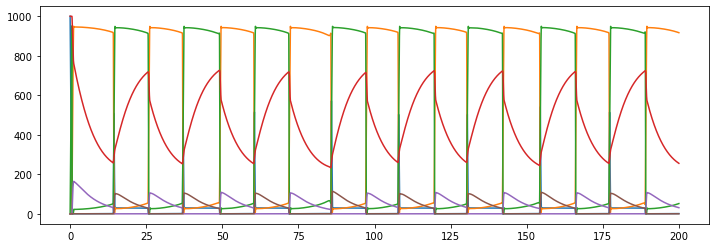

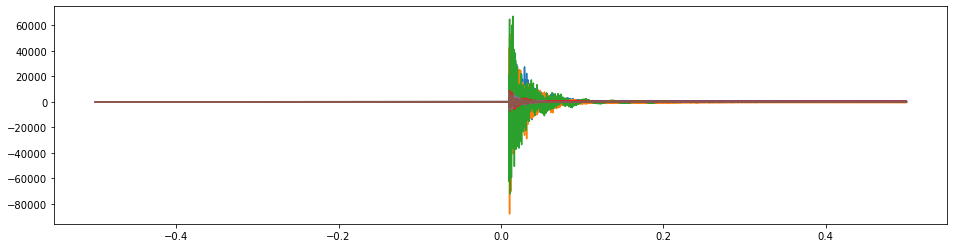

In [4]:
#test run
trange=200
#true positive from Table S1
k = [47.,103.,10.,1060.,1060.,10.,103.,47.,209.,10.,19.,12.,12.,19.,10.,209.]
K = [1.47,0.008,57.4,2.59,2.59,57.4,0.008,1.47,87.,38.,4.3,0.04,0.04,4.3,38.,87.]


#k =[ 10.85316352,   9.36358998,  65.79385637,   4.96788527,   2.35059231,
#   8.75153155, 620.0150273,    1.82554891,  43.13262203,   1.75530847,
#  1.88872387, 158.72827231,  20.131113,     5.83331195,  63.8174205,
#   3.18194618]
#K =[3.79406381e-02, 8.02037150e+01, 3.12402500e-01, 4.88735773e+01,
# 9.91363776e+00, 9.72772348e+01, 3.02097524e+02, 1.68872812e-01,
# 1.87100060e+01, 1.59134369e-01, 1.05538783e+02, 2.54389392e-02,
# 3.48872539e-02, 5.93665866e+00, 1.88992868e-01, 4.90489275e+00,]

S0 = np.asarray([1000., 0., 0., 1000., 0., 0.]) # initial state of the substrates.
#S11は総量からほかを引くことで算出していた。#計算量削減のためかな
ts=np.arange(0, trange, 0.02)
S = odeint(func=DvD, y0=S0, t=ts, args=(k, K), atol=5.0e-4, rtol=5.0e-4, full_output=0)
print(type(S))
print(S.shape)
#print(info)

plt.figure(figsize=(12,4))
for i in range(S.shape[1]):
  plt.plot(ts,S.T[i])
  peak_count, _ = find_peaks(S.T[i])
  print(len(peak_count))

plt.figure(figsize=(16,4))
freq = np.fft.fftfreq(S.shape[0])

intg_hfq = 0

for i in range(S.shape[1]):
  fk = np.fft.fft(S.T[i])
  #plt.xlim(-0.01,0.01)
  fk[(freq<0.01)]=0
  plt.plot(freq,fk)
  #plt.plot(fk)
  peak_count, _ = find_peaks(S.T[i])
  print(len(peak_count))
  intg_hfq += fk.real.sum()
print(intg_hfq)


<class 'numpy.ndarray'>
(10000, 6)
1
2
1
0
4
1
1
2
1
0
4
1
66107.6244090898


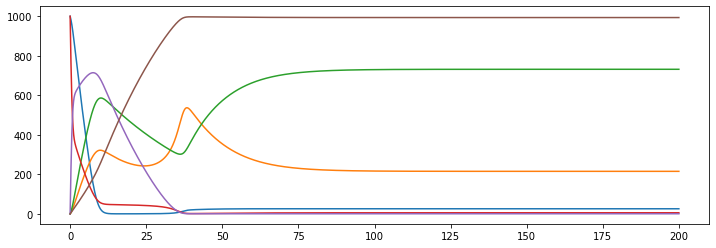

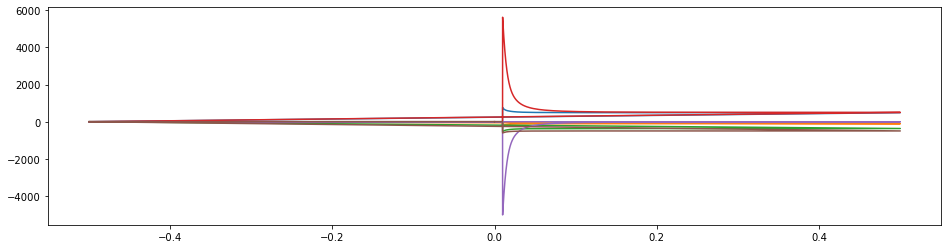

In [5]:
#test run random
trange=200
k, K = gen_kK()

#true positive from Table S1
#k = [47.,103.,10.,1060.,1060.,10.,103.,47.,209.,10.,19.,12.,12.,19.,10.,209.]
#K = [1.47,0.008,57.4,2.59,2.59,57.4,0.008,1.47,87.,38.,4.3,0.04,0.04,4.3,38.,87.]


S0 = np.asarray([1000., 0., 0., 1000., 0., 0.]) # initial state of the substrates.
#S11は総量からほかを引くことで算出していた。#計算量削減のためかな
ts=np.arange(0, trange, 0.02)
S = odeint(func=DvD, y0=S0, t=ts, args=(k, K), atol=5.0e-4, rtol=5.0e-4, full_output=0)
print(type(S))
print(S.shape)
#print(info)

plt.figure(figsize=(12,4))
for i in range(S.shape[1]):
  plt.plot(ts,S.T[i])
  peak_count, _ = find_peaks(S.T[i])
  print(len(peak_count))

plt.figure(figsize=(16,4))
freq = np.fft.fftfreq(S.shape[0])

intg_hfq = 0

for i in range(S.shape[1]):
  fk = np.fft.fft(S.T[i])
  #plt.xlim(-0.01,0.01)
  fk[(freq<0.01)]=0
  plt.plot(freq,fk)
  #plt.plot(fk)
  peak_count, _ = find_peaks(S.T[i])
  print(len(peak_count))
  intg_hfq += fk.real.sum()
print(intg_hfq)


In [6]:
print(k)
print(K)

#[ 10.85316352   9.36358998  65.79385637   4.96788527   2.35059231
#   8.75153155 620.0150273    1.82554891  43.13262203   1.75530847
#   1.88872387 158.72827231  20.131113     5.83331195  63.8174205
#   3.18194618]
#[3.79406381e-02 8.02037150e+01 3.12402500e-01 4.88735773e+01
# 9.91363776e+00 9.72772348e+01 3.02097524e+02 1.68872812e-01
# 1.87100060e+01 1.59134369e-01 1.05538783e+02 2.54389392e-02
# 3.48872539e-02 5.93665866e+00 1.88992868e-01 4.90489275e+00]

[ 55.67430118  51.40469971  85.79770128   8.27010058   9.67039627
   1.27378745 290.67366707   1.02984756 634.72912714  80.67421107
 150.69834455   8.47657427 543.7247283    4.84417501 500.78558474
 360.36340892]
[2.09380219e+01 1.08745194e+01 3.81410524e+02 4.80089911e+01
 2.80863471e+00 5.38075520e+02 1.18442474e+01 2.05349779e+00
 4.38828009e-01 3.02417222e+01 8.38595638e+02 1.05636569e+02
 1.38038286e-02 8.02559556e+01 8.59008077e+02 4.72301859e-02]


In [ ]:
def objective(trial):
  trange=1000
  #k, K = gen_kK()
  #min=0,max10^5で探索範囲を指定してた
  k_list=[]
  K_list=[]

  for i in range(16):
    k_name = "k_"+str(i)
    K_name = "K_"+str(i)
    #tmp_k = trial.suggest_loguniform(k_name,0.1,1e5)
    #tmp_K = trial.suggest_loguniform(K_name,0.01,1e3)
    tmp_k = trial.suggest_discrete_uniform(k_name,0,2e4,10)
    tmp_K = trial.suggest_discrete_uniform(K_name,0,1e2,0.01)
    k_list.append(tmp_k)
    K_list.append(tmp_K)
  k_list=np.array(k_list)
  K_list=np.array(K_list)


  S0 = np.asarray([1000., 0., 0., 1000., 0., 0.]) # initial state of the substrates.
  #S11は総量からほかを引くことで算出していた。#計算量削減のためかな
  ts=np.arange(0, trange, 0.02)
  S = odeint(func=DvD, y0=S0, t=ts, args=(k, K), atol=5.0e-4, rtol=5.0e-4, full_output=0)
  
  peak_sum =0
  
  freq = np.fft.fftfreq(S.shape[0])

  intg_hfq = 0
  for i in range(S.shape[1]):
    fk = np.fft.fft(S.T[i])
    #plt.xlim(-0.01,0.01)
    fk[(freq<0.01)]=0
    #plt.plot(freq,fk)
    #plt.plot(fk)
    peak_count, _ = find_peaks(S.T[i])
    #print(len(peak_count))
    peak_sum += len(peak_count)
    intg_hfq += fk.real.sum()
    #print(intg_hfq)

  #score = peak_sum/6
  score = intg_hfq + peak_sum * 1e5
  #print("score",score)

  return -score

study = optuna.create_study()
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=10000)

[I 2020-12-31 20:25:14,408] A new study created in memory with name: no-name-cf6504fc-6d48-42a9-b6a6-76627092fab9


In [ ]:
print(study.best_value)
print(study.best_params)
print("best:")


In [ ]:
k = []
K = []

for i in range(16):
    k_name = "k_" + str(i)
    print(k_name,study.best_params[k_name])

    
    K_name = "K_" + str(i)
    print(K_name,study.best_params[K_name])

    k.append(study.best_params[k_name])
    K.append(study.best_params[K_name])

In [ ]:

trange=1000

S0 = np.asarray([1000., 0., 0., 1000., 0., 0.]) # initial state of the substrates.
#S11は総量からほかを引くことで算出していた。#計算量削減のためかな
ts=np.arange(0, trange, 0.02)

S = odeint(func=DvD, y0=S0, t=ts, args=(k, K), atol=5.0e-4, rtol=5.0e-4, full_output=0)
print(type(S))
print(S.shape)
#print(info)

plt.figure(figsize=(12,4))
for i in range(S.shape[1]):
  plt.plot(ts,S.T[i])
  peak_count, _ = find_peaks(S.T[i])
  print(len(peak_count))
plt.savefig("best_result.png")